### Testing algorithms for exponential decay curve fitting

In [1]:
import numpy as np
import scipy.optimize
from neuroanalysis.data import TSeries
from neuroanalysis.fitting.exp import exp_decay, Exp, normalized_rmse
import neuroanalysis.fitting.exp as exp_fitting
import matplotlib.pyplot as plt

In [2]:
def estimate_tau_Šimurda(data: TSeries, tau_guess: float = None):
    """data should be baseline of 0"""
    # Šimurda 2020 method:
    Δt = tau_guess or data.dt * 100
    curve_start = data.time_at(data.data.argmax())
    val_at = lambda _t: data.value_at(_t)
    # threshold = val_at(curve_start) / 10
    # later = data.time_slice(curve_start, None)
    # first = later.data[later.data < threshold].argmin()
    # if first >= 0:
    #     Δt = min(max(later.time_at(first) - curve_start, Δt), 60 * data.dt)
    tmin = curve_start
    tmax = tmin + 0.5

    def K(t):
        ret = (val_at(t) - val_at(t + Δt)) / (val_at(t) - val_at(t + 2 * Δt))
        # if np.isnan(ret):
        #     print(f"Problem! K = {val_at(t):g} - {val_at(t + Δt):g} / {val_at(t):g} - {val_at(t + 2 * Δt):g}")
        return ret
    # Ks = np.array([val for t0 in np.arange(tmin, tmax, data.dt) if (val := K(t0)) > 0.5 and val < 1])
    Ks = np.array([K(t0) for t0 in np.arange(tmin, tmax, data.dt)])
    # if K >= 1 or K <= 0.5:
    #     print(f"Problem! K = {K:g} = {val_at(tmin):g} - {val_at(tmin + Δt):g} / {val_at(tmin):g} - {val_at(tmin + 2 * Δt):g}")
    tau = np.median(-Δt / np.log((1 - Ks) / Ks))
    return tau

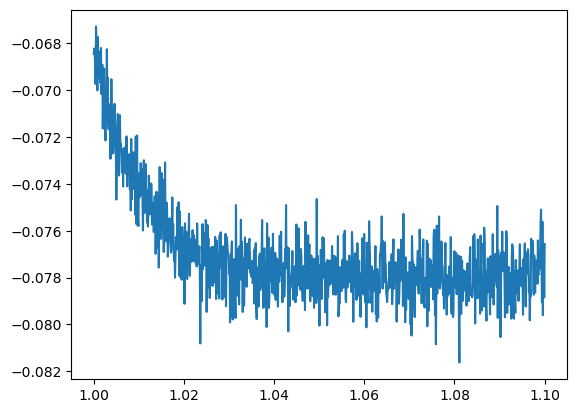

In [3]:
# a function for generating a noisy exponential decay

t = np.linspace(0, 0.1, 1000)
yoffset = -0.078
yscale = 0.01
tau = 0.01
noise = 0.001

def mk_data(params, noise):
    params = [params[x] for x in ('yoffset', 'yscale', 'tau')]
    y = exp_decay(t, *params) + np.random.normal(0, noise, len(t))
    return TSeries(y, time_values=t)

params = {'yoffset': yoffset, 'yscale': yscale, 'tau': tau}
data = mk_data(params, noise)
data.t0 = 1
plt.plot(data.time_values, data.data)


## Rough parameter estimation for initialization

In [4]:
def estimate_exp_params(data):
    # wrap param estimation to look like other fitters used here
    params = exp_fitting.estimate_exp_params(data)
    # params['tau'] = estimate_tau_Šimurda(data, params['tau'])
    return {'fit': params}
est_params = estimate_exp_params(data)['fit']
print(yoffset, yscale, tau)
print(*est_params)

-0.078 0.01 0.01
-0.07715740579252849 0.005470806770937198 0.0014014014014014364 1.0


In [5]:
# function for testing a fitting algorithm against a grid of exponentials varying in scale, offset, and tau

def check_accuracy(method):
    taus = 10 ** np.linspace(-3, -1, 5)
    yscales = np.append(10 ** np.linspace(-3, -1, 5), -0.01)
    noise = 0.001
    results = np.zeros((len(taus), len(yscales)), dtype=object)
    for i,tau in enumerate(taus):
        for j,yscale in enumerate(yscales):
            yoffset = np.random.uniform(-0.1, 0.1)
            data = mk_data({'yoffset': yoffset, 'yscale': yscale, 'tau': tau}, noise)
            result = method(data)
            est_params = result['fit']
            results[i, j] = {
                'nrmse': normalized_rmse(data, est_params),
                'params': est_params,
                'data': data,
                'result': result,
                'fit_data': exp_decay(data.time_values, *est_params),
            }
            
    fig, ax = plt.subplots(len(taus), len(yscales), figsize=(15, 15))
    for i in range(len(taus)):
        ax[i, 0].set_ylabel(f"tau={taus[i]:.3f}")
        for j in range(len(yscales)):
            ax[0, j].set_title(f"yscale={yscales[j]:.3f}")

            result = results[i, j]
            data = result['data']
            ax[i, j].plot(data.time_values, data.data)
            ax[i, j].plot(data.time_values, result['fit_data'])
            ax[i, j].set_title(f"nrmse={result['nrmse']:.3f}")

    return results


## Check performance of rough estimation algorithm
(we expect this to be a mess, but to come reasonably close in all cases)

/home/luke/docs/AIBS/neuroanalysis/neuroanalysis/fitting/exp.py:15: RuntimeWarning: divide by zero encountered in divide
  return yoffset + yscale * np.exp(-(t-xoffset) / tau)
/home/luke/docs/AIBS/neuroanalysis/neuroanalysis/fitting/exp.py:15: RuntimeWarning: invalid value encountered in divide
  return yoffset + yscale * np.exp(-(t-xoffset) / tau)


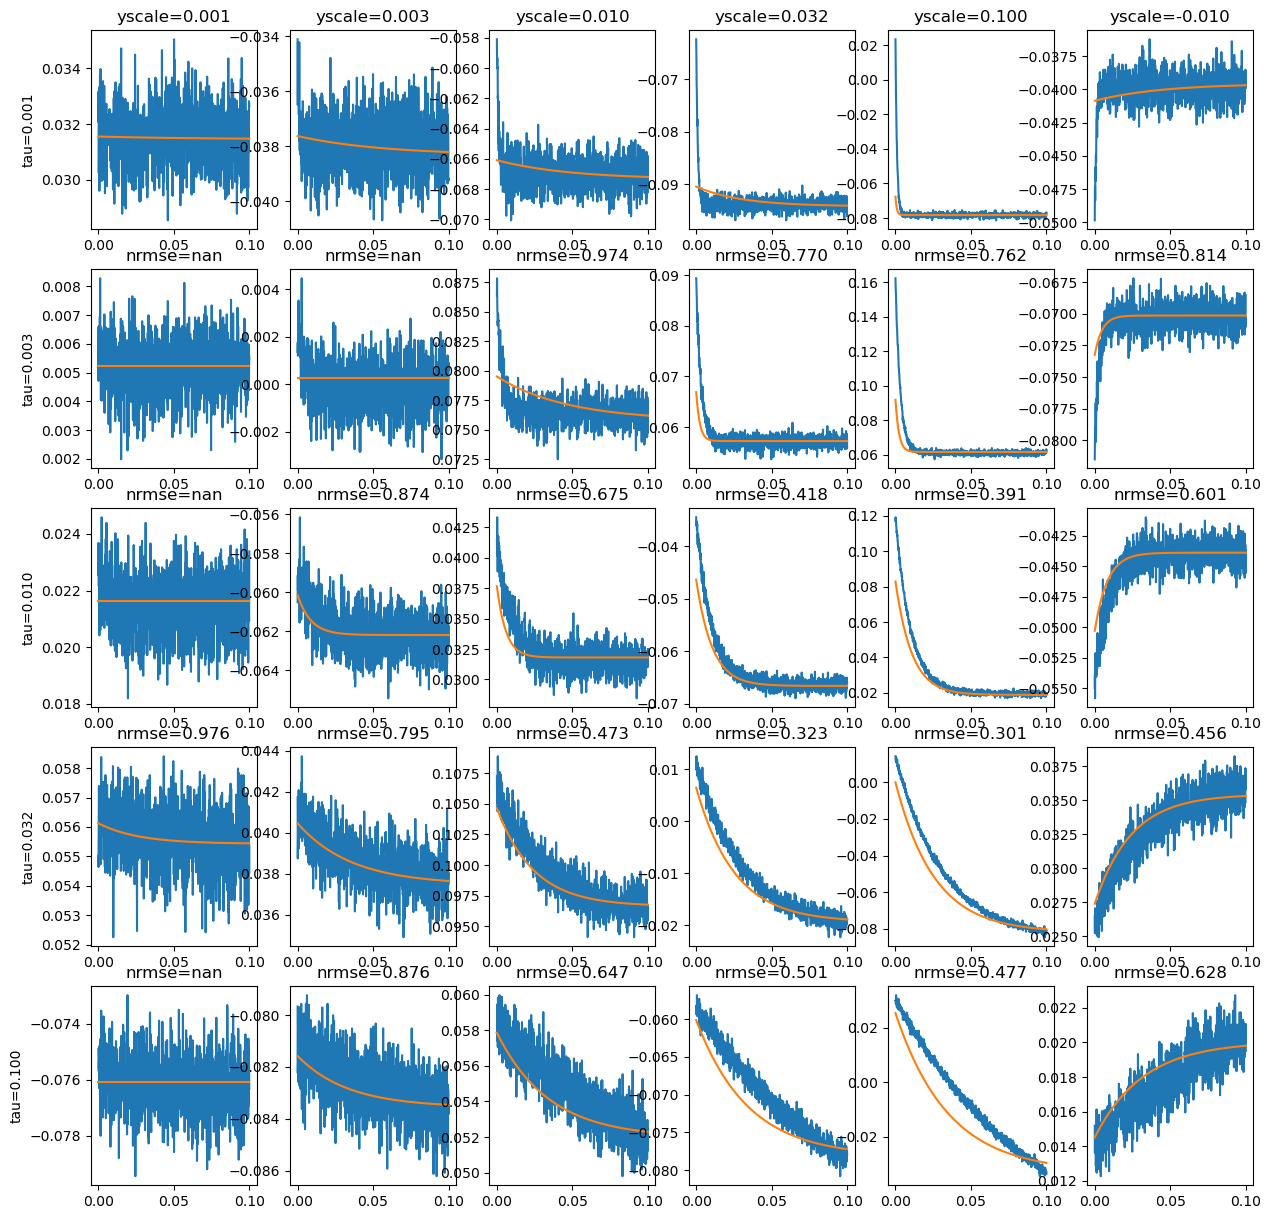

In [6]:
check_accuracy(estimate_exp_params);

## Test the fitting.exp.exp_fit() function

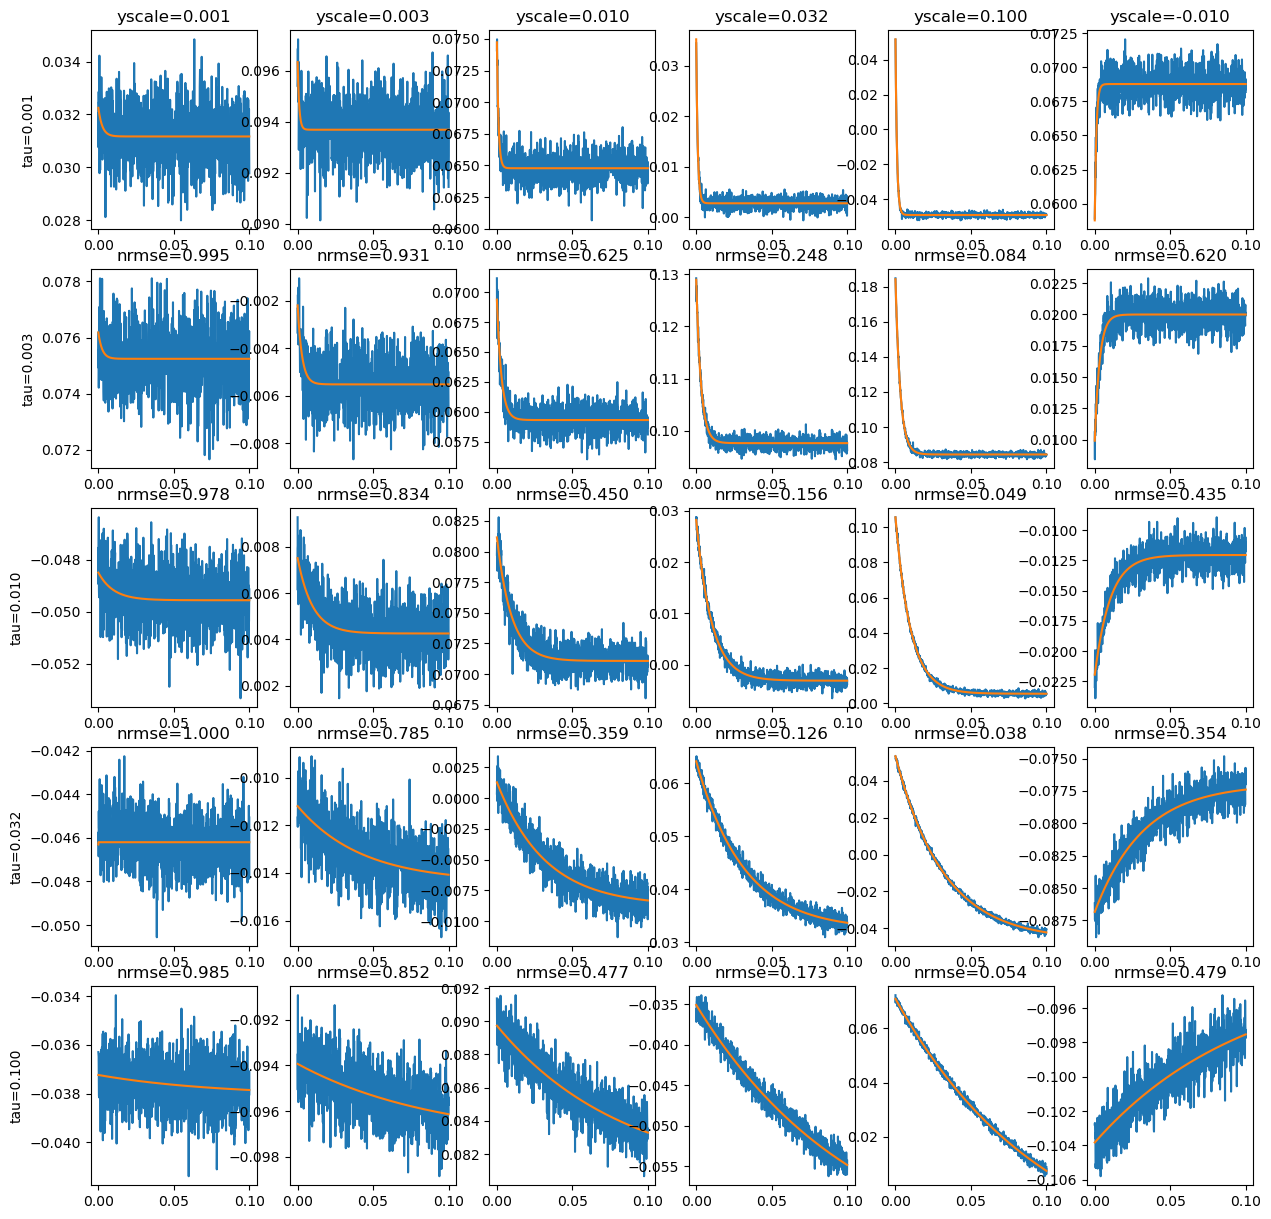

In [7]:
# def logged_exp_decay(data):
#     log = []
#     def _exp(t, yoffset, yscale, tau):
#         result = exp_decay(t, yoffset, yscale, tau)
#         nmse = normalized_rmse(data, (yoffset, yscale, tau))
#         log.append({'params': (yoffset, yscale, tau), 'nmse': nmse})
#         return result
#     return _exp, log

def curve_fit(data):
    # initial_guess = estimate_exp_params(data)['fit']
    # bounds = ([-np.inf, -np.inf, 0], [np.inf, np.inf, np.inf])
    # fit = scipy.optimize.curve_fit(
    #     f=exp_decay, 
    #     xdata=data.time_values, 
    #     ydata=data.data, 
    #     p0=initial_guess, 
    #     bounds=bounds, 
    #     # ftol=1e-8, gtol=1e-8,
    # )
    # return {'fit': fit[0], 'result': fit}
    result = exp_fitting.exp_fit(data)
    params = result['fit']
    return {'fit': params, 'result': result}

results = check_accuracy(curve_fit)

## Test fitting.exp.Exp()

/home/luke/docs/AIBS/neuroanalysis/neuroanalysis/fitting/exp.py:15: RuntimeWarning: overflow encountered in exp
  return yoffset + yscale * np.exp(-(t-xoffset) / tau)
/home/luke/miniconda3/envs/neuroanalysis/lib/python3.11/site-packages/lmfit/minimizer.py:141: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
/home/luke/docs/AIBS/neuroanalysis/neuroanalysis/fitting/exp.py:15: RuntimeWarning: divide by zero encountered in divide
  return yoffset + yscale * np.exp(-(t-xoffset) / tau)
/home/luke/docs/AIBS/neuroanalysis/neuroanalysis/fitting/exp.py:15: RuntimeWarning: invalid value encountered in divide
  return yoffset + yscale * np.exp(-(t-xoffset) / tau)


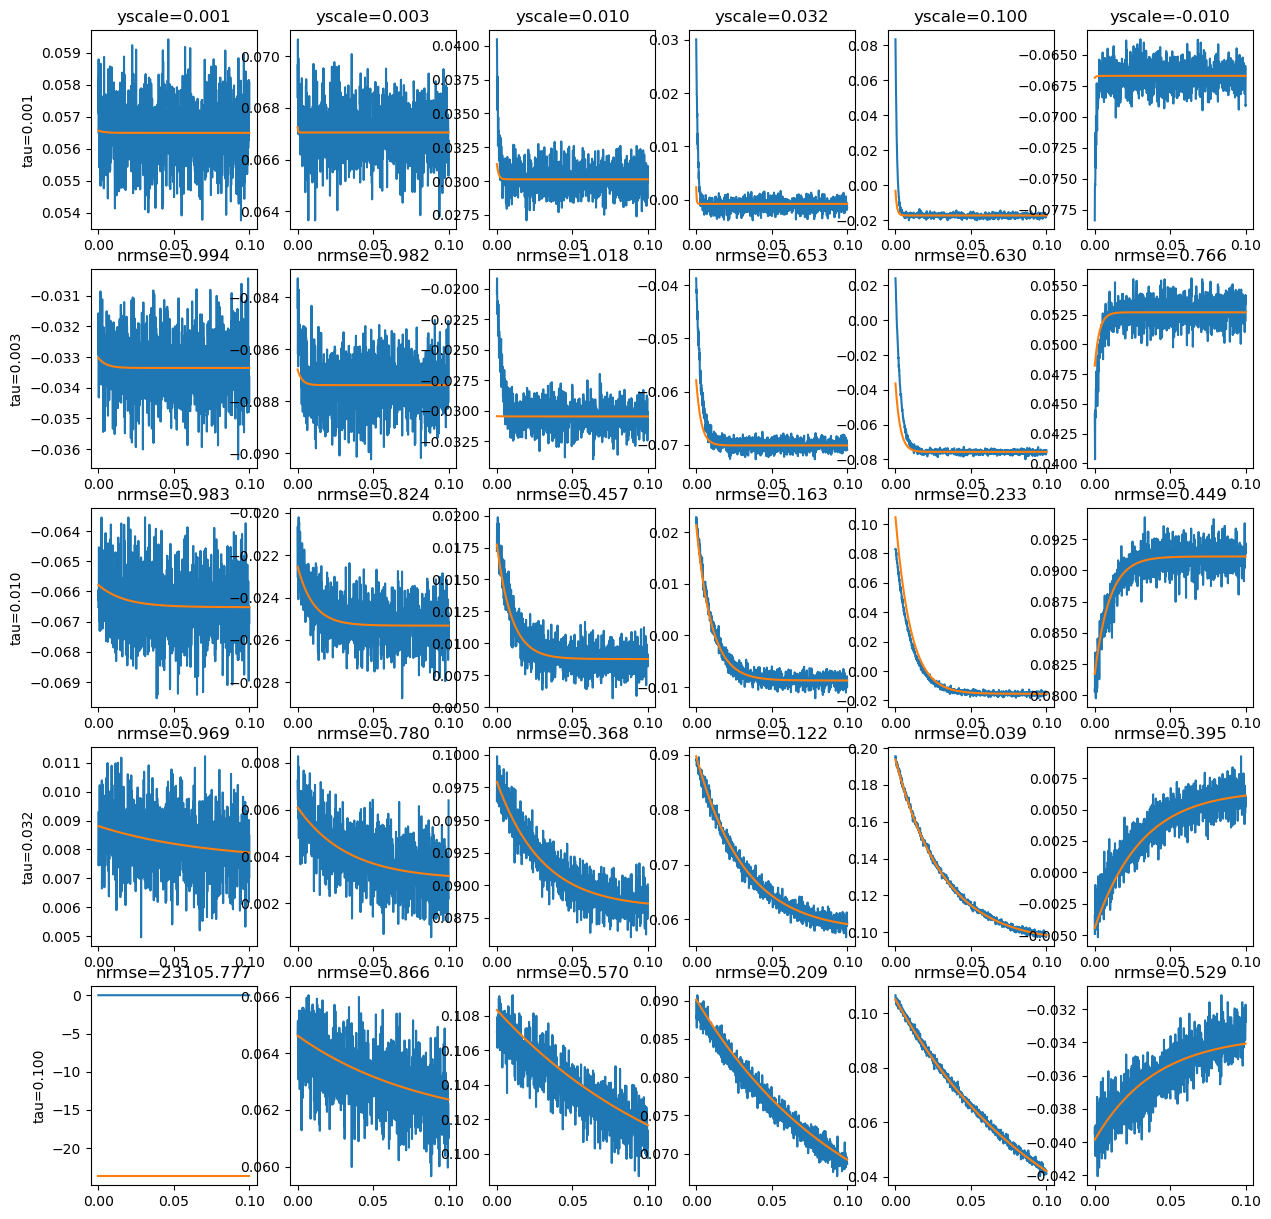

In [8]:
from neuroanalysis.fitting.exp import Exp

def exp_fitter(data):
    init = estimate_exp_params(data)['fit']
    params = {
        'xoffset': data.time_values[0],
        'yoffset': init[0],
        'amp': init[1],
        'tau': init[2],
    }
    fitter = Exp()
    result = fitter.fit(x=data.time_values, data=data.data, params=params)
    fit_params = result.best_values['yoffset'], result.best_values['amp'], result.best_values['tau']
    return {'fit': fit_params, 'result': result}

results = check_accuracy(exp_fitter)

## Test a simpler method: minimize only over tau
..while directly computing the optimal yscale / yoffset

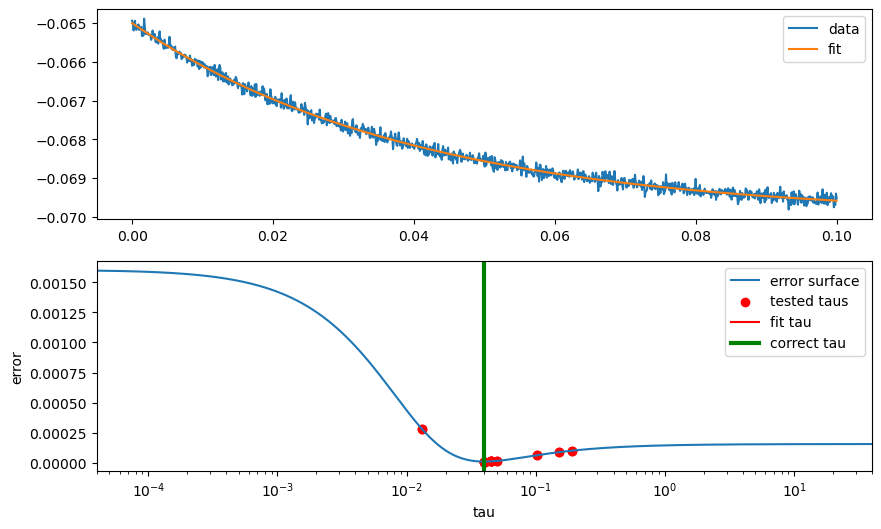

In [9]:
from neuroanalysis.fitting.exp import exact_fit_exp
from neuroanalysis.fitting.exp import best_exp_fit_for_tau


def calc_exp_error_curve(tau, data:TSeries):
    """Calculate the error surface for an exponential with *tau* and noisy *data* 
    """
    taus = tau * 10**np.linspace(-3, 3, 1000)
    errs = []
    for i in range(len(taus)):
        exp_y, err, yscale, yoffset = best_exp_fit_for_tau(taus[i], data.time_values, data.data)
        errs.append(err)
    return taus, errs

test_params = {'tau': 40e-3, 'yscale': 5e-3, 'yoffset': -70e-3}
test_exp = mk_data(params=test_params, noise=1e-4)

taus, errs = calc_exp_error_curve(test_params['tau'], test_exp)

fit = exact_fit_exp(test_exp)
memory = fit['memory']
fit_yoffset, fit_yscale, fit_tau = fit['fit']
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

ax[0].plot(test_exp.time_values, test_exp.data, label='data')
ax[0].plot(test_exp.time_values, memory[fit_tau][3], label='fit')
ax[0].legend()

ax[1].plot(taus, errs, label='error surface')
ax[1].set_xlabel('tau')
ax[1].set_ylabel('error')
ax[1].set_xscale('log')
ax[1].scatter(list(memory.keys()), [v[2] for v in memory.values()], color='r', label='tested taus')
ax[1].axvline(fit_tau, color='r', label='fit tau')
ax[1].axvline(test_params['tau'], color='g', linewidth=3, label='correct tau')
ax[1].set_xlim(taus.min(), taus.max())
ax[1].legend()
# for k,v in memory.items():
#     print(k,v)
# print(taus[np.argmin(errs)])

/home/luke/miniconda3/envs/neuroanalysis/lib/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


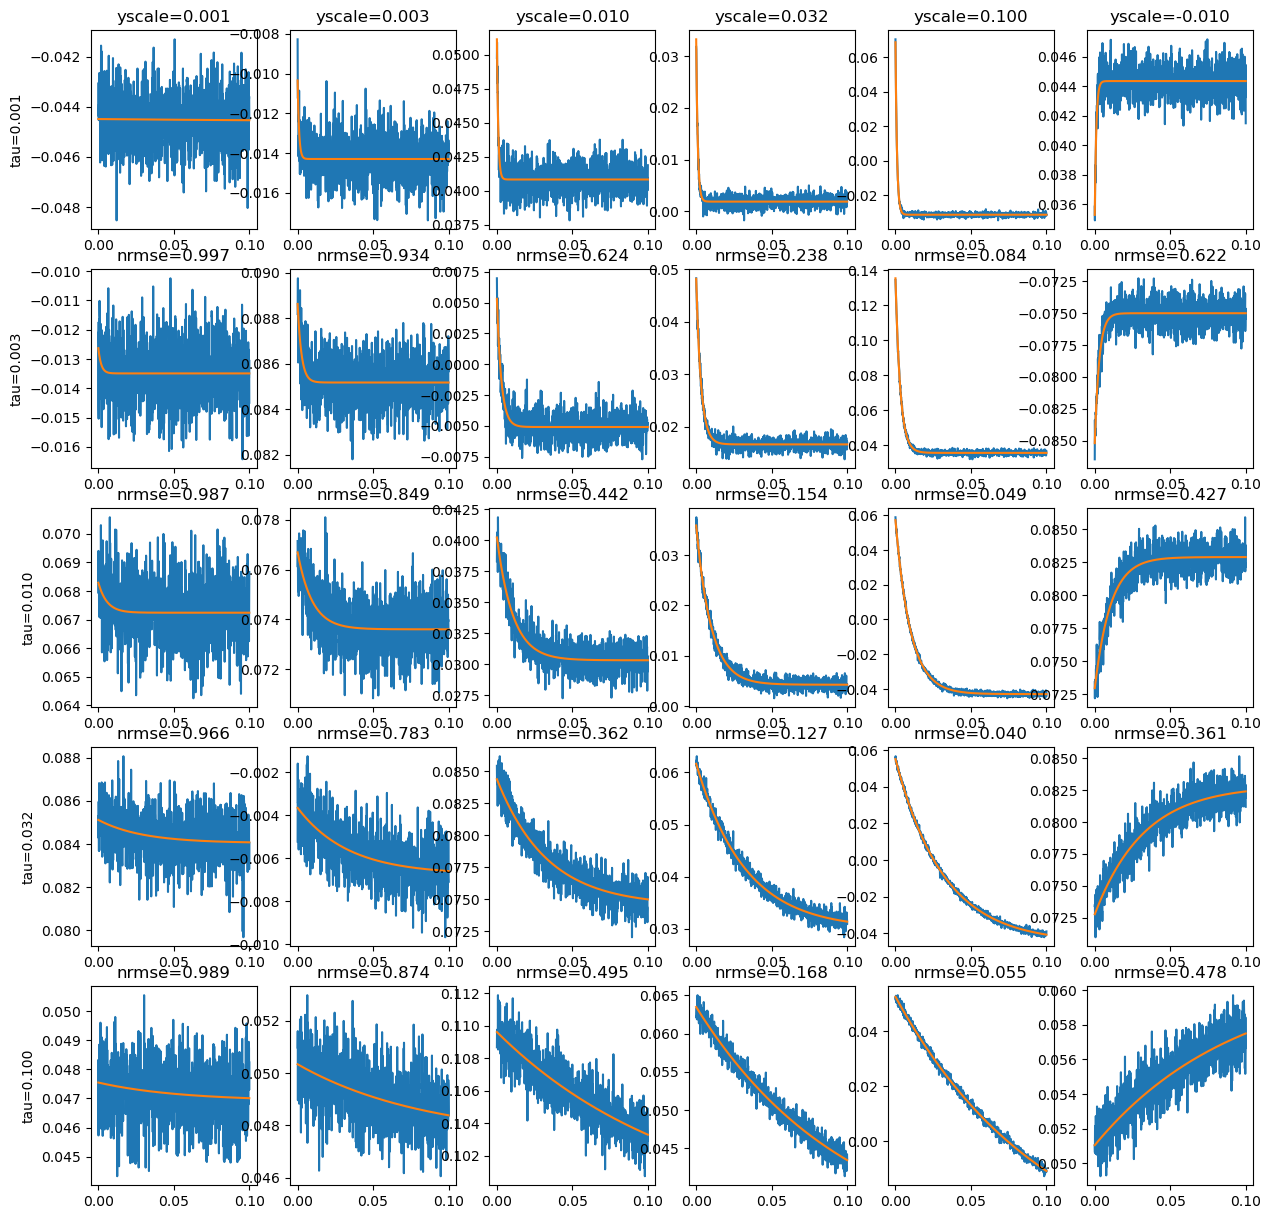

In [10]:

results = check_accuracy(exact_fit_exp)

In [11]:

def fit_linear(t, y):
    """Return slope, intercept, and mse of the best fit line to the data"""
    result = np.polyfit(t, y, 1, full=True)
    slope, intercept = result[0]
    residuals = result[1]
    mse = residuals[0] / len(y)
    return slope, intercept, mse

def fit_exp(t, y):
    """Return yoffset, yscale, tau

    Assume y = yoffset + yscale * exp(-t / tau)

    """
    # first estimate yoffset and yscale
    yoffset = -0.09#y[-len(y)//10:].mean()
    yscale = np.max(y) - yoffset
    ymax = scipy.stats.scoreatpercentile(y, 50)
    print("yscale", yscale)
    print("yoffset", yoffset)
    print("ymax", ymax)
    t = t - t[0]

    # first fine the yoffset that best linearizes the data

    log = []
    best_result = None
    def err(params):
        nonlocal best_result, log
        # params are just yoffset
        yoffset = params[0]

        # take log of y, and normalize to 1
        y_adjusted = y - yoffset
        mask = y_adjusted > 0
        ye = np.log(y_adjusted[mask])

        # fit a line to the log of the data
        slope, intercept, mse = fit_linear(t[mask], ye)
        tau = -1 / slope
        yscale = np.exp(intercept)
        params = (yoffset, yscale, tau)

        # calculate mse from the fit to original data
        fit = yoffset + yscale * np.exp(-t / tau)
        mse = np.mean((fit - y)**2)

        log.append((params, mse))
        if best_result is None or mse < best_result[0]:
            best_result = (mse, params)
        return mse

    for yoffset in np.linspace(-0.0781, -0.0779, 11):
        err((yoffset,))
    # result = scipy.optimize.minimize(
    #     fun=err, 
    #     x0=[yoffset-yscale], 
    #     bounds=[(None, ymax)],
    #     tol=1e-12,
    #     options={'ftol': 1e-18, 'gtol': 1e-18, 'maxiter': 1000},
    #     method='L-BFGS-B',
    #     # method='Nelder-Mead',
    #     # method='Powell',
    #     # method='SLSQP',
    # )
    # print(result.message)
    return best_result[1], log

In [12]:

fit, log = fit_exp(t, y)


def show_fit(data, fit, ax1, ax2, ax3):
    fit_yoffset, fit_yscale, fit_tau = fit
    t = data.time_values - data.time_values[0]
    fit_y = fit_yoffset + fit_yscale * np.exp(-t / fit_tau)
    def map(y):
        return np.log((y - fit_yoffset) / fit_yscale)

    ax1.plot(data.time_values, map(data.data), label='data')
    ax1.plot(data.time_values, map(fit_y), label='fit', color='r')
    ax2.plot(data.time_values, data.data, label='data')
    ax2.plot(data.time_values, fit_y, label='fit', color='r')
    err = (data.data - fit_y) ** 2
    mse = np.mean(err)
    ax3.plot(data.time_values, err, label='mse')
    ax3.set_xlabel(f'mse: {mse:.2g}')

n = 7
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(4, n)
ax1 = fig.add_subplot(gs[0, :])
ax1.set_yscale('log')
# 10 small plots in second row
axs = [fig.add_subplot(gs[1, i]) for i in range(n)]
axs2 = [fig.add_subplot(gs[2, i]) for i in range(n)]
axs3 = [fig.add_subplot(gs[3, i]) for i in range(n)]
# plot mse over time in top
ax1.plot([x[1] for x in log])
# plot fits in bottom
for i,step in enumerate(np.linspace(0, len(log)-1, n, dtype=int)):
    ax1.axvline(step, color='k', alpha=0.5)
    show_fit(data, log[step][0], axs[i], axs2[i], axs3[i])
    if i > 0:
        axs[i].set_yticks([])
        axs2[i].set_yticks([])
    axs[i].set_xticks([])
    axs2[i].set_xticks([])
    axs3[i].set_xticks([])
    axs2[i].set_xlabel("%0.2g" % log[step][1])


NameError: name 'y' is not defined